# AutoRegressive Integrated Moving Average (ARIMA) Model Forecasting

In [1]:
%matplotlib auto
import joblib
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
sns.set()

Using matplotlib backend: agg


/home/plam/virtualenvs/rides/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# Load clean
raw_pd = pd.read_csv('../data/interim/trips_per_hour_dropped_na_and_all_outliers_under_001_and_over_999.csv')
raw_pd.request_date = pd.to_datetime(raw_pd.request_date)
ts = raw_pd.set_index(raw_pd.request_date)['trip_counts']
ts_df = pd.DataFrame(ts)

<IPython.core.display.Javascript object>


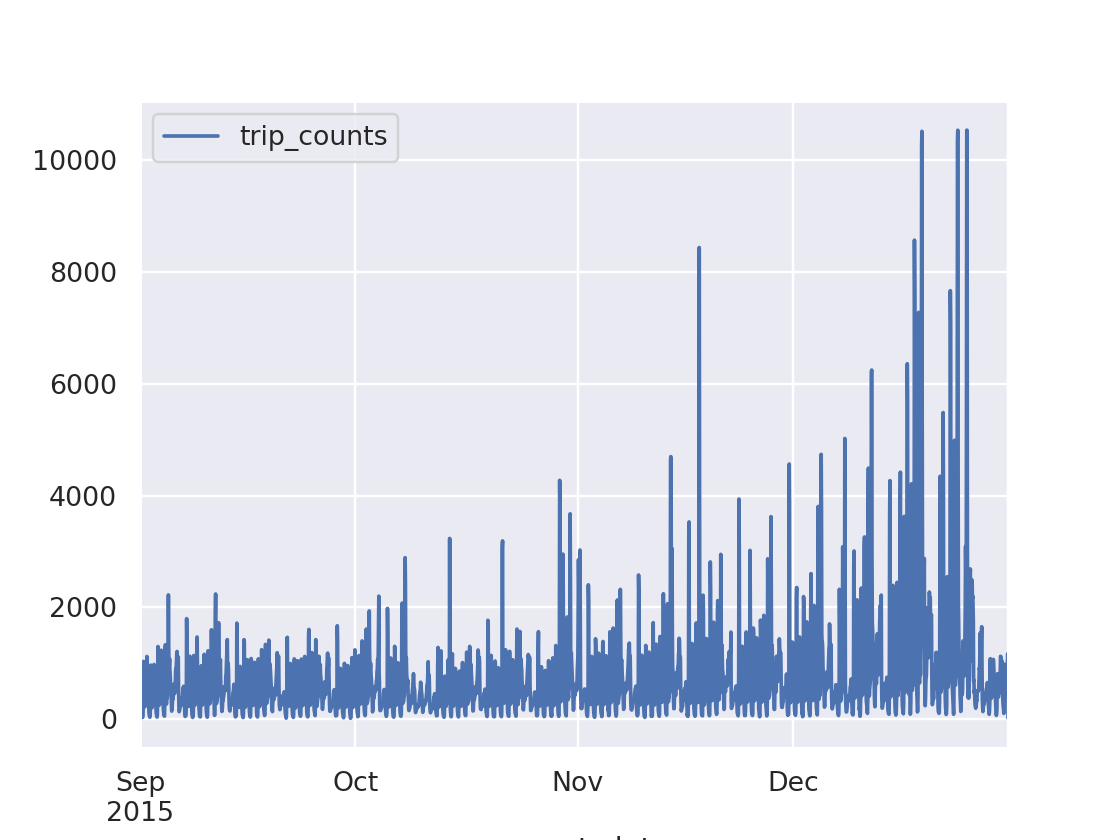

In [6]:
ts_df.plot()
plt.show()

## Test the stationarity of the timeseries

We conduct the ADF, KPSS and PP tests to determine the stationarity of the ts and prepare for ARIMA.

A stationary series is one where the values of the series is not a function of time.

We need to find a way to make the series stationary if we want to model it.

In [7]:
# The following tests, test for different stationarity types.

n_adf = pm.arima.utils.ndiffs(ts, test='adf')
n_kpss = pm.arima.utils.ndiffs(ts, test='kpss')
n_pp = pm.arima.utils.ndiffs(ts, test='pp')

(n_adf, n_kpss, n_pp)
# KPSS is non zero which suggests action should be taken. Later more analytical tests show the same.

(0, 1, 0)

#### Good news: ADF null hypothesis rejected
In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

In [33]:
from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(ts)  # Whether the timeseries needs to be diffed

(0.01, False)

#### Mixed news: KPSS null hypothesis rejected
In econometrics, Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests are used for testing a null hypothesis that an observable time series is stationary around a deterministic trend (i.e. trend-stationary) against the alternative of a unit root.

In [34]:
from pmdarima.arima.stationarity import KPSSTest,

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = KPSSTest(alpha=0.05)
adf_test.should_diff(ts)  # Whether the timeseries needs to be diffed

(0.01, True)

#### Better news: PP null hypothesis rejected
In statistics, the Phillips–Perron test (named after Peter C. B. Phillips and Pierre Perron) is a unit root test. That is, it is used in time series analysis to test the null hypothesis that a time series is integrated of order 1.

In [9]:
from pmdarima.arima.stationarity import PPTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = PPTest(alpha=0.05)
adf_test.should_diff(ts)  # Whether the timeseries needs to be diffed

(0.01, False)

#### What does that mean?
- In statistics, the order of integration, denoted I(d), of a time series is a summary statistic, which reports the minimum number of differences required to obtain a covariance-stationary series.



#### Yes, but what does that mean?

- WSS random processes only require that 1st moment (i.e. the mean) and autocovariance do not vary with respect to time and that the 2nd moment is finite for all times.

### Visualize Autocorrelation and Frequencies

The graphs suggest strong autocorrelation, indicationg dependence with previous lags 
and two strong frequencies, a strong sign of seasonality.

<IPython.core.display.Javascript object>


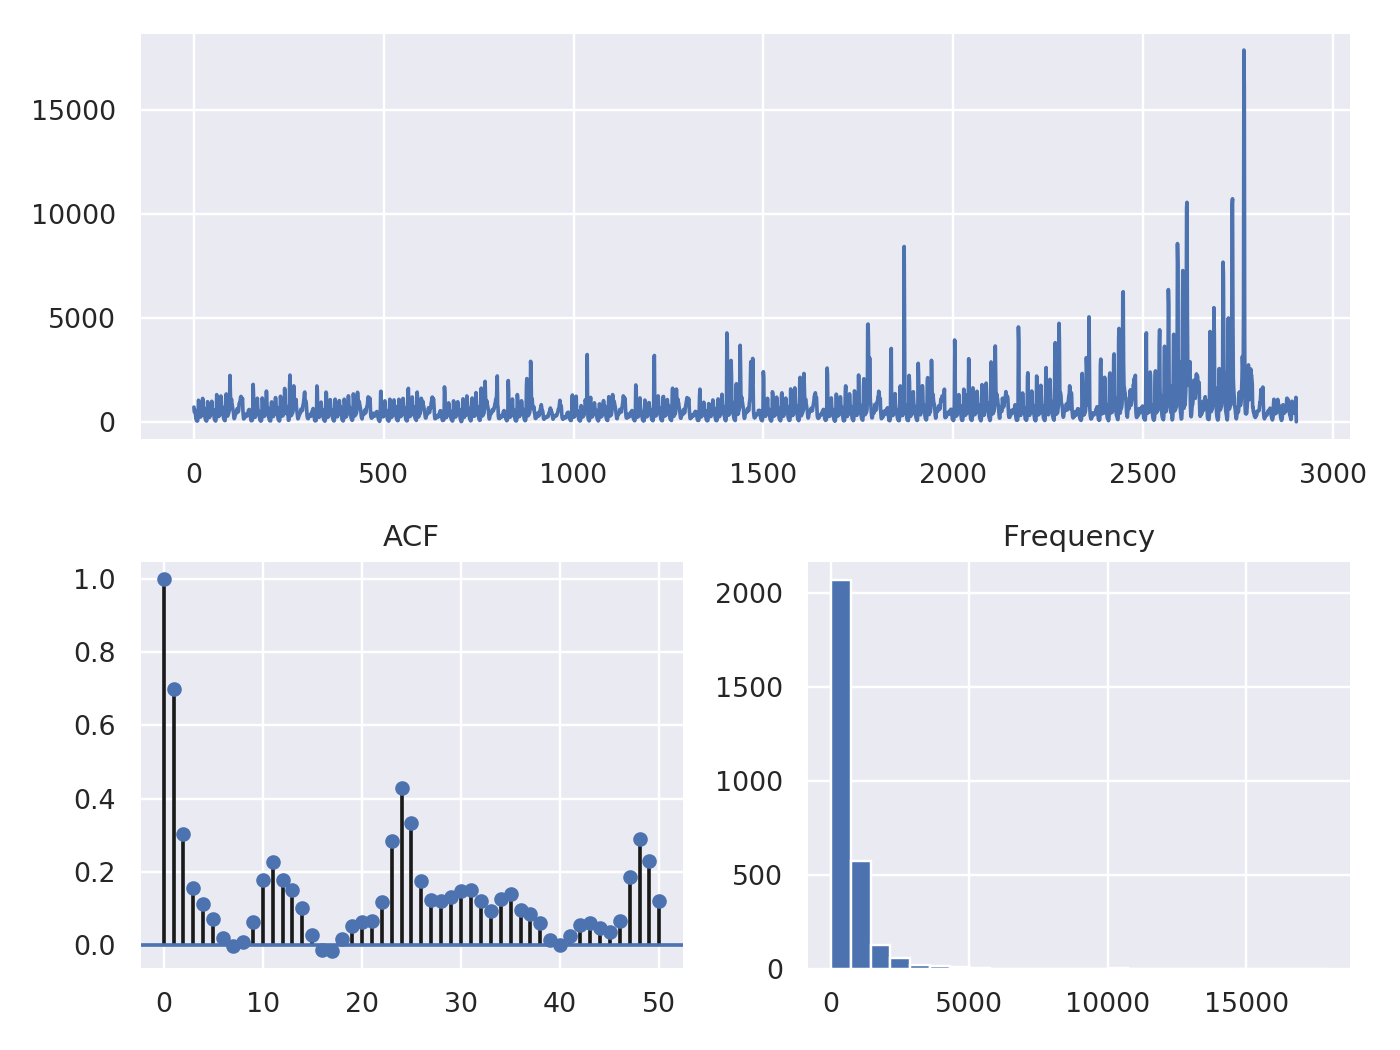

In [36]:
pm.utils.tsdisplay(ts)

### Prepare a simple train-test split

In [4]:
from pmdarima.model_selection import train_test_split

train_len = int(len(ts)*.99)
test_len = len(ts) - train_len
y_train, y_test = train_test_split(ts, train_size=train_len)
train_len, test_len


(2875, 30)

## Naive Auto ARIMA fitting

An ARIMA model is characterized by 3 terms: p, d, q

- p is the order of the AR term

- q is the order of the MA term

- d is the number of differencing required to make the time series stationary

Simple ARIMA does not support seasonality. Our series has some seasonality in it. Let's start with a model that is completely naive of seasonality.

In [ ]:
fit1_filepath = '../data/models/naive-auto-arima'
try:
    fit1 = joblib.load(fit1_filepath)
except:
    fit1 = pm.auto_arima(y_train, m=1, trace=True, suppress_warnings=True)
    joblib.dump(fit1, fit1_filepath)

In [23]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2875
Model:               SARIMAX(1, 1, 3)   Log Likelihood              -22270.276
Date:                Thu, 16 Jan 2020   AIC                          44552.552
Time:                        23:55:24   BIC                          44588.332
Sample:                             0   HQIC                         44565.450
                               - 2875                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1573      0.291      0.540      0.589      -0.414       0.728
ar.L1          0.2682      0.043      6.265      0.000       0.184       0.352
ma.L1         -0.2183      0.042     -5.254      0.000      -0.300      -0.137
ma.L2         -0.6301      0.011    -57.857      0.000      -0.651      -0.609
ma.L3         -0.1340      0.039     -3.438      0.001      -0.210      -0.058
sigma2      3.145e+05   2557.422    122.985      0.000     3.1e+05     3.2e+05
===================================================================================
Ljung-Box (Q):                      934.28   Jarque-Bera (JB):            216385.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.26   Skew:                             4.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>


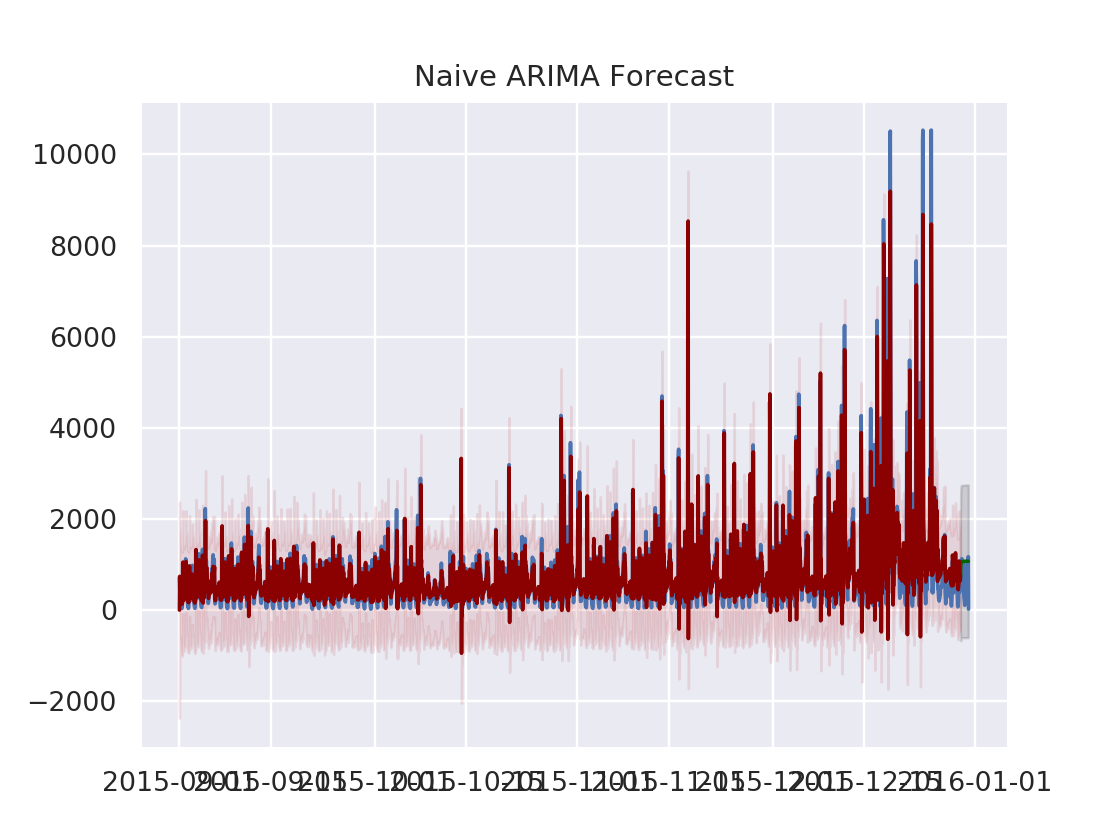

In [24]:
# Forecast
n_periods = test_len
fc, confint = fit1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(y_train.index[-1], periods = n_periods, freq='1H')


# FC make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Forecast in samples
fc_in_sample, confint_in_sample = fit1.predict_in_sample(return_conf_int=True)
index_of_fc_in_sample = pd.date_range(y_train.index[0], periods = train_len, freq='1H')


# FC in sample make series for plotting purpose
fc_series_in_sample = pd.Series(fc_in_sample, index=index_of_fc_in_sample)
lower_series_in_sample = pd.Series(confint_in_sample[:, 0], index=index_of_fc_in_sample)
upper_series_in_sample = pd.Series(confint_in_sample[:, 1], index=index_of_fc_in_sample)


# Plot Original
plt.plot(ts_df)

# Plot FC
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

# Plot FC in sample
plt.plot(fc_series_in_sample, color='darkred')
plt.fill_between(lower_series_in_sample.index, 
                 lower_series_in_sample, 
                 upper_series_in_sample, 
                 color='r', alpha=.15)



plt.title("Naive ARIMA Forecast")
plt.show()

### Plot standardized residual

<IPython.core.display.Javascript object>


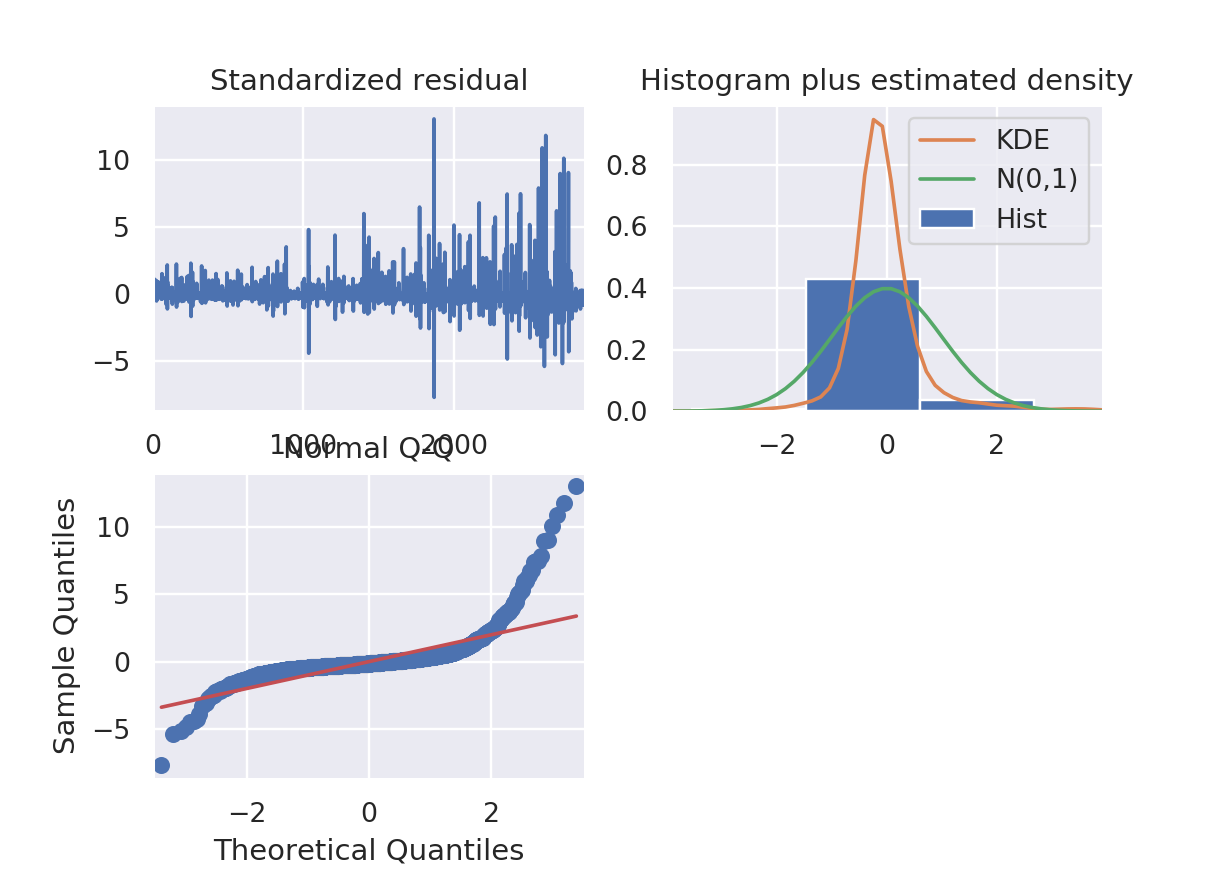

In [25]:
fit1.plot_diagnostics(figsize=(7,5))
plt.show()

### Calculate RMSE for out-of-sample prediction

In [26]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, fc)))


Test RMSE: 545.974


## Result Intepretation

The model follows suite with the timeseries in-sample, but may reach negative values. Cross validation of RMSE could provide a in-sample prediction metric, but lack of time prevents it.

Out of sample prediction is conservative with wide variance. 

By plotting the model diagnostics, we see that the standardized residual seems to contain some more information, as it looks like a pattern has remained embedded. The histogram and Q-Q plot do not suggest a normal distribution and the autocorrelation is out of bounds.

# Embed seasonality with SARIMA
The problem with plain ARIMA model is it does not support seasonality.

If your time series has defined seasonality, then, go for SARIMA which uses seasonal differencing.

Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.

So, the model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series.

## Improving on the auto ARIMA model: SARIMA

We already know that ARIMA does not cover seasonality and our model has been seen to excibit both hour-of-day and day-of-week seasonality. We may use the parameter `m` to depict seasonality like so:

- 24 - hour of day
- 7 - day of week
- 12 - monthly
- 52 - week of year

For our case we will need m = 24*7 = 168. This, however, requires infinite computation, so we will stick to just showcasing the hour-of-day seasonality with `m=24`.



In [ ]:
fit2_filepath = '../models/sarima-with-seasonality-24-on-clean-data'
try:
    fit2 = joblib.load(fit2_filepath)
except:
    fit2 = pm.auto_arima(y_train, m=24, seasonal=True, trace=True, suppress_warnings=True)
    joblib.dump(fit2, fit2_filepath)

In [12]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2875
Model:             SARIMAX(1, 1, 3)x(1, 0, 1, 24)   Log Likelihood              -21869.145
Date:                            Fri, 17 Jan 2020   AIC                          43754.290
Time:                                    04:16:34   BIC                          43801.998
Sample:                                         0   HQIC                         43771.488
                                           - 2875                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.002      0.104      0.917      -0.003       0.003
ar.L1          0.3602      0.013     28.735      0.000       0.336       0.385
ma.L1         -0.2959      0.013    -22.903      0.000      -0.321      -0.271
ma.L2         -0.5936      0.014    -42.032      0.000      -0.621      -0.566
ma.L3         -0.1066      0.002    -52.811      0.000      -0.111      -0.103
ar.S.L24       0.9992      0.001   1800.130      0.000       0.998       1.000
ma.S.L24      -0.9413      0.003   -288.770      0.000      -0.948      -0.935
sigma2      3.005e+05   2573.834    116.744      0.000    2.95e+05    3.06e+05
===================================================================================
Ljung-Box (Q):                      298.75   Jarque-Bera (JB):            231572.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.28   Skew:                             3.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>


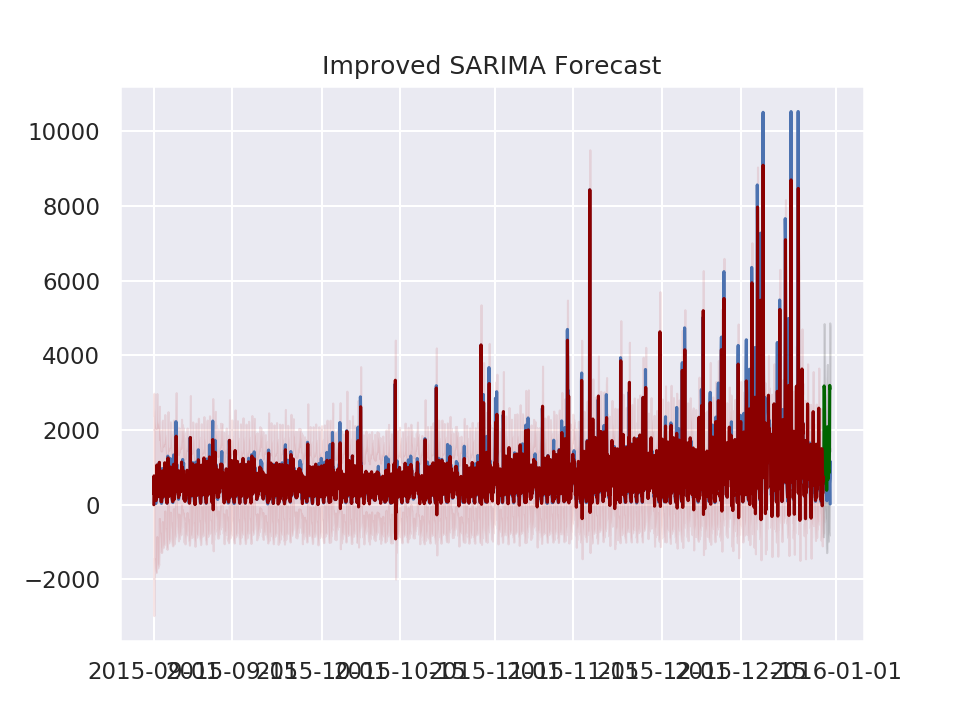

In [8]:
# Forecast
n_periods = test_len
fc, confint = fit2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(y_train.index[-1], periods = n_periods, freq='1H')


# FC make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Forecast in samples
fc_in_sample, confint_in_sample = fit2.predict_in_sample(return_conf_int=True)
index_of_fc_in_sample = pd.date_range(y_train.index[0], periods = train_len, freq='1H')


# FC in sample make series for plotting purpose
fc_series_in_sample = pd.Series(fc_in_sample, index=index_of_fc_in_sample)
lower_series_in_sample = pd.Series(confint_in_sample[:, 0], index=index_of_fc_in_sample)
upper_series_in_sample = pd.Series(confint_in_sample[:, 1], index=index_of_fc_in_sample)


# Plot Original
plt.plot(ts_df)

# Plot FC
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

# Plot FC in sample
plt.plot(fc_series_in_sample, color='darkred')
plt.fill_between(lower_series_in_sample.index, 
                 lower_series_in_sample, 
                 upper_series_in_sample, 
                 color='r', alpha=.15)



plt.title("Improved SARIMA Forecast")
plt.show()

<IPython.core.display.Javascript object>


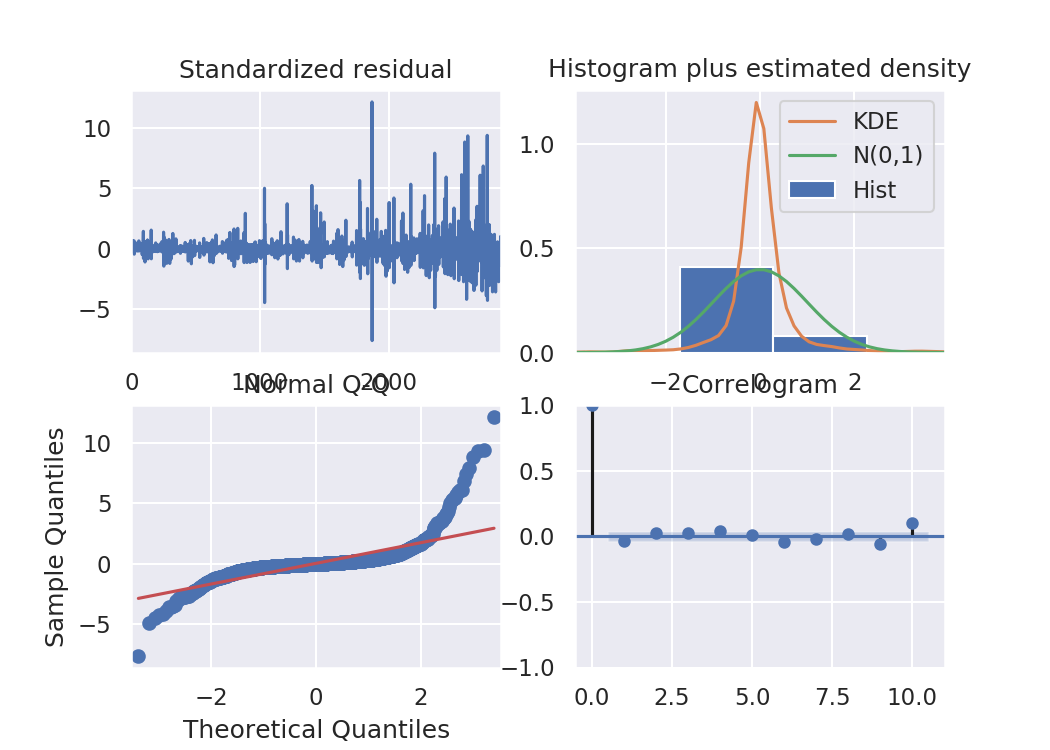

In [10]:
fit2.plot_diagnostics(figsize=(7,5))
plt.show()

In [11]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, fc)))


Test RMSE: 1009.208


## Result Intepretation

RMSE imporved slightly. If there is time, cross in-series RMSE validation will be performed.

By plotting the model diagnostics below, we see that the standardized residual seems to contain some more information, as it looks like a pattern has remained embedded. The histogram and Q-Q plot do not suggest a normal distribution.

Still, we can see how the forecast includes a seasonality component, as we wanted. RMSE has not improved much. Neither has AIC.

# Conclusion

We have examined stationarity and several tests to defined it's type. The ARIMA model was introduced and attempts to model our series with and without simple seasonality components were made.

In the next section, we will examine that the frequency components are very stationary, decompose the timeseries and attempt another prediction, over the trend.